In [1]:
import gurobipy as gb
import numpy as np
import math

from gurobipy import GRB
from utils import file_reader as fr
from utils import data_generator as dg
from utils import data_visualizer as dv


# First MSSP example

The paper is based on the comparison of different variants of the __Multiple Shortest Path Problem with Path Deconfliction (MSPP-PD)__, a problem that seeks to route $n$ agents between respective source nodes ($s_k \; \text{for} \; k = 1,...,n$) and terminus nodes ($t_k \; \text{for} \; k=1,...,n$) over a directed network to minimize both the total distance travelled and the degree to which the respective agent's path conflict.

Before studying these variants we show how to formulate and solve a __Multiple Shortest Path Problem (MSPP)__ that is the same problem as the MSPP-PD, but it does not care about the agent's path conflicts.

What follow is based on section 3.2 of the paper


## Read Data

In this section we read the file containing the netwoork instance that we'll use to solve the MSPP.  
This instance is the one shown in Fig. 5 in section 3.2 of the paper


In [2]:
synthetic_5x5_df = fr.read_networks_csv("data/d_it_ij_5x5_1it.csv",
                                        along="cols")

# show some arcs with related weights of the network
synthetic_5x5_df.T.head()


it1
0 5  3.0
  6  1.0
1 5  1.0
  6  1.0
  7  1.0

## Manage data

In this section we define the variables that we'll use to formulate and solve the MSPP problem starting from the dataframe containing the network instance


In [3]:
# nodes in the network
nodes = dg.get_nodes(synthetic_5x5_df)
network_shape = (5,5)
nodes_grid = np.array(nodes).reshape(network_shape).T

  
# weighted arcs in the network
# the weight of each arc represents the ditance between 2 nodes
w_arcs = [dg.WArc(i, j, synthetic_5x5_df.loc["it1", (i, j)], idx)
          for idx, (i, j) in enumerate(synthetic_5x5_df.columns)]


# agets that has to be routed
agents_sources = [0, 2, 3, 4]
agents_terminus = [20, 22, 23, 24]
agents_idxs = [0, 1, 2, 3]
agents = [dg.Agent(s, t, idx) for s, t, idx in zip(
    agents_sources, agents_terminus, agents_idxs)]


## Problem formulation and solution

In this section we formulate and solve the MSPP problem using Gurobi.  
The formulations follows the one reported in section 2.2 of the paper


Create the problem

In [4]:
MSPP_pb = gb.Model("First MSPP")
# MSPP_pb.setParam("OutputFlag", 0)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-12-10


Define decision variables

In [5]:
var_shape = len(w_arcs), len(agents)

X = MSPP_pb.addMVar(var_shape,
                    vtype=GRB.BINARY,  # 5) Binary constraints
                    name="X")


Define the objective function.  
In the MSPP we penalize solutions that makes agents travel higher distances

In [6]:
# 1) Objective function
MSPP_pb.setObjective(
    gb.quicksum(
        arc.w * X[arc.idx, agent.idx]
        for arc in w_arcs for agent in agents
    ),
    GRB.MINIMIZE
)

Add constraints

In [7]:
# 4) Flow constraints

def compute_flow(X, node, w_arcs, agent):
    """Compute the flow in a given node for a particular agent

    The flow is defined as the difference between outgoing and ingoing edges traversed by the agent in that node

    Args:
        X (gb.MVar): X decision variables of a MSPP or MSPP-PD
        node (int): node under consideration
        w_arcs (list): list of weighted arcs that represent the network instance
        agent (Agent): the agent for which to compue the flow

    Returns:
        gb.MLinExpr: an expression for the computed flow 
    """

    flow_out = gb.quicksum(
        X[arc.idx, agent.idx]
        for arc in w_arcs if arc.i == node
    )
    flow_in = gb.quicksum(
        X[arc.idx, agent.idx]
        for arc in w_arcs if arc.j == node
    )
    return flow_out - flow_in


for agent in agents:
    for node in nodes:
        if node == agent.source:
            MSPP_pb.addConstr(compute_flow(X, node, w_arcs, agent) == 1)
        elif node == agent.terminus:
            MSPP_pb.addConstr(compute_flow(X, node, w_arcs, agent) == -1)
        else:
            MSPP_pb.addConstr(compute_flow(X, node, w_arcs, agent) == 0)


Solve the problem

In [8]:
MSPP_pb.optimize()

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Core(TM) i5-7200U CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 100 rows, 208 columns and 416 nonzeros
Model fingerprint: 0x0dd877d3
Variable types: 0 continuous, 208 integer (208 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 3e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 24.0000000
Presolve removed 100 rows and 208 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.08 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 2: 16 24 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.600000000000e+01, best bound 1.600000000000e+01, gap 0.0000%


## Report results

In this section we report the results that we've obtained 

In [9]:
print("Result of the optimization is:")
if MSPP_pb.Status == 2:
    print("optimal")
elif MSPP_pb.Status == 3:
    print("infeasible")
elif MSPP_pb.Status == 5:
    print("unbounded")
else:
    print("Some other return status")

Result of the optimization is:
optimal


In [10]:
print(f"Minimum distance covered is {MSPP_pb.ObjVal}")

Minimum distance covered is 16.0


And we also print the paths that each agent has to follow

In [11]:
for agent in agents:
    print(f"Agent {agent.idx} will follow the path:")
    for arc in w_arcs:
        if math.isclose(X.x[arc.idx, agent.idx], 1):
            print(f"{arc.i}->{arc.j}", end="\t")
    print()


Agent 0 will follow the path:
0->6	6->12	12->16	16->20	
Agent 1 will follow the path:
2->7	7->12	12->17	17->22	
Agent 2 will follow the path:
3->7	7->12	12->17	17->23	
Agent 3 will follow the path:
4->8	8->14	14->18	18->24	


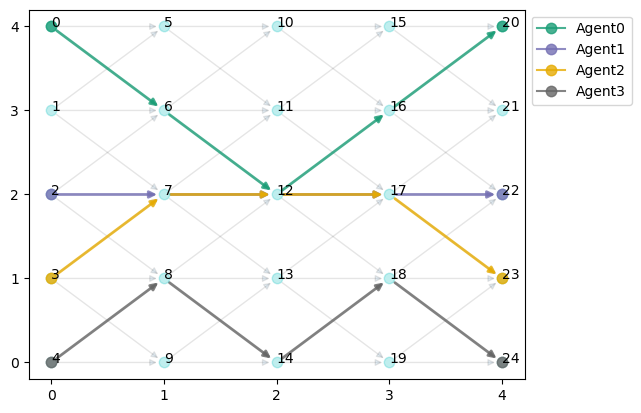

In [12]:
dv.plot_solution(X.x, nodes_grid, w_arcs, agents)


Notice that the solution found, even if it is not the same as the one reported in Fig. 5 of the paper, is still optimal (total distance covered is 16) bcs solution to the MSPP is not unique as noticed in the paper
 